In [1]:
import torchmdao
import torch
import matplotlib.pyplot as plt
from pdb import set_trace
%matplotlib inline

Define an object to define a wing and to compute its induced drag.
We will initialize as a square wing.

In [2]:
class Wing(torchmdao.ComputeObject):
    def __init__(self):
        self.half_span = 5.0 # 10 m span
        # establish a computational grid (using the lifting line change of variables)
        self.spanwise_loc = -self.half_span * torch.cos(torch.linspace(torch.pi / 2, torch.pi, 51))
        self.section_lengths = torch.diff(self.spanwise_loc)
        self.spanwise_loc = self.spanwise_loc[1:] # remove the root node
        # initialize the chords variable which we will optimize
        self.chords =  1.0 * torch.ones_like(self.spanwise_loc) # initially 1 m constant chord
        # specify that the airfoil gives zero lift at -3deg and that it is untwisted
        self.alpha_sections = torch.zeros_like(self.spanwise_loc)
        self.alpha_0s = torch.deg2rad(-3.0*torch.ones_like(self.spanwise_loc))
        # specify a target Cl
        self.Cl_target = torch.as_tensor(0.5)
        
    def compute(self):
        """ compute the induced drag coefficient for the wing. """
        # compute the wing area for the full wing (both halves)
        assert torch.abs(self.section_lengths.sum() - self.half_span) < 1e-6
        self.wing_area = torch.sum(self.section_lengths * self.chords)
        # compute the aspect ratio
        self.AR = (2*self.half_span)**2/self.wing_area
        # compute the induced drag coefficient and span efficiency factor
        wing = torchmdao.lifting_line.LiftingLineWing(
            self.spanwise_loc, self.chords, self.alpha_sections, self.alpha_0s, self.AR
        )
        wing.solve(Cl=self.Cl_target)
        self.Cd = wing.induced_drag_coeff()
        self.span_efficiency_factor = wing.span_efficiency_factor
        self.neg_span_efficiency_factor = -self.span_efficiency_factor
        
    def plot(self):
        """ plot the wing assuming the spar is at 1/3 chord. """
        plt.figure(figsize=(8,3))
        plt.title("Wing planview")
        x = torch.cat([self.spanwise_loc, torch.flip(self.spanwise_loc, (0,))])
        y = torch.cat([0.33*self.chords, -0.66*torch.flip(self.chords, (0,))])
        plt.fill_between(x, y.detach(), color='k')
        plt.xlabel("Spanwise position (m)")
        plt.axis('equal')

Optimize the chord distribution subject to a span equality constraint (which is a linear constraint given the parameterization).

[ 00:11:40 ] INFO: Initial objective: -0.921.
[ 00:11:40 ] INFO: Beginning optimization.
[ 00:11:40 ] INFO: niter: 0001, fun: -0.9208, constr_violation: 1, execution_time: 0.0s
[ 00:11:41 ] INFO: niter: 0010, fun: -0.9715, constr_violation: 8.88e-16, execution_time: 1.1s
[ 00:11:42 ] INFO: niter: 0020, fun: -0.9921, constr_violation: 8.88e-16, execution_time: 2.2s
[ 00:11:44 ] INFO: niter: 0030, fun: -0.9954, constr_violation: 0, execution_time: 3.7s
[ 00:11:46 ] INFO: niter: 0040, fun: -0.9971, constr_violation: 0, execution_time: 5.7s
[ 00:11:48 ] INFO: niter: 0050, fun: -0.9983, constr_violation: 4.44e-16, execution_time: 8.3s
[ 00:11:51 ] INFO: niter: 0060, fun: -0.9986, constr_violation: 0, execution_time: 10.3s
[ 00:11:53 ] INFO: niter: 0070, fun: -0.9989, constr_violation: 0, execution_time: 12.5s
[ 00:11:55 ] INFO: niter: 0080, fun: -0.9993, constr_violation: 0, execution_time: 14.5s
[ 00:11:56 ] INFO: niter: 0090, fun: -0.9994, constr_violation: 8.88e-16, execution_time: 16.2s

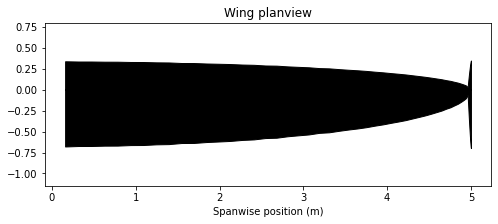

In [3]:
wing = Wing()
optimizer = torchmdao.Optimizer(
    initial_design_variables=[torchmdao.DesignVariable(name="chords", lower=0.)],
    compute_object=wing,
    outputs=[
        torchmdao.Output(name="neg_span_efficiency_factor"),
        torchmdao.Output(name="wing_area", lower=4.0, upper=4.0, linear=True),
    ],
    objective_index=0,
)
optimizer.optimize(maxiter=100, display_step=10)
wing.plot()

TODO:
- [ ] figure out what's happening at the tip
- [ ] generate a gif of the optimization procedure
- [ ] plot a figure with the spanwise sectional lift coefficient and lift distribution
- [ ] compare the performance when the analytical gradients are turned off so that finite differencing must be used.